# PHASE 2 PROJECT

## Business problem

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

# Data Description
we chose 3 data sets that give budget, revenue and film metadata which are essential to answer the business question (which film types make the most money):
 
 * `tn.movie_budget.csv` -production budgets & gross receipts. can help compute ROI,profit etc(loaded as `movie_budgets`)

 * `tmdb.movies.csv` - movies metadata (genres,release dates,language,popularity,votes etc) (loaded as `movie_tmdb`)
 * `bom.movies_gross.csv`-(loaded as `movie_gross`)
 * `im.db` with tables `movie_rating` and `movie_basics`

In [780]:
#import relevant libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # optional for nicer plotting
import sqlite3

from scipy.stats import ttest_ind, ttest_1samp, chi2_contingency, norm

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid", rc={"figure.dpi":100})

#### loading the datasets

In [781]:
# loading the datasets

movie_budgets = pd.read_csv("../Data/tn.movie_budgets.csv", low_memory=False)
tmdb_movies = pd.read_csv("../Data/tmdb.movies.csv", low_memory=False)
movie_gross = pd.read_csv('../Data/bom.movie_gross.csv', low_memory=False)

# quick peek
print(movie_budgets.shape, tmdb_movies.shape, movie_gross.shape)
movie_budgets.head()

(5782, 6) (26517, 10) (3387, 5)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [782]:
#check columns
print(movie_budgets.columns)
print(tmdb_movies.columns)
print(movie_gross.columns)

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')
Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')


#### Loading the `im.db` sqlite database

In [783]:

# Connect to the imdb-style database
conn = sqlite3.connect("../Data/im.db")

# List all tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in im.db:")
print(tables)



Tables in im.db:
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


In [784]:
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics;", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings;", conn)

In [785]:
movie_basics.columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')

In [786]:
movie_ratings.columns


Index(['movie_id', 'averagerating', 'numvotes'], dtype='object')

# Data Exploration and Cleaning

### 1. `tbmd.movies.csv` read as `tmbd_movies`

In [787]:
tmdb_movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [788]:
print(tmdb_movies.columns)
print(tmdb_movies.info())
print(tmdb_movies.isna().sum().sort_values(ascending=False))
print(tmdb_movies.duplicated().sum())

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB
None
Unnamed: 0           0
genre_ids            0
id                   0
o

#### Cleaning steps:
1. Ensure `release_date` is datetime and extract the year.
2. Clean the `title` column (lowercase, trimmed).
3. Handle missing values.
4. Keep only relevant columns for analysis.

In [789]:
# Convert release_date to datetime
tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'], errors='coerce')

# Extract year
tmdb_movies['year'] = pd.to_datetime(tmdb_movies['release_date'].dt.year)


# Clean title
tmdb_movies['title_clean'] = tmdb_movies['title'].str.lower().str.strip()

#drop column unnamed
tmdb_movies.drop(columns=['Unnamed: 0'],inplace=True)



In [790]:
tmdb_movies.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,year,title_clean
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,1970-01-01 00:00:00.000002010,harry potter and the deathly hallows: part 1
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,1970-01-01 00:00:00.000002010,how to train your dragon
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,1970-01-01 00:00:00.000002010,iron man 2
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,1970-01-01 00:00:00.000001995,toy story
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,1970-01-01 00:00:00.000002010,inception


In [791]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          26517 non-null  object        
 1   id                 26517 non-null  int64         
 2   original_language  26517 non-null  object        
 3   original_title     26517 non-null  object        
 4   popularity         26517 non-null  float64       
 5   release_date       26517 non-null  datetime64[ns]
 6   title              26517 non-null  object        
 7   vote_average       26517 non-null  float64       
 8   vote_count         26517 non-null  int64         
 9   year               26517 non-null  datetime64[ns]
 10  title_clean        26517 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 2.2+ MB


### 2. `tn.movie_budget.csv` read as `movie_budgets`

In [792]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [793]:
print(movie_budgets.columns)
print(movie_budgets.info())
print(movie_budgets.isna().sum().sort_values(ascending=False))
print(movie_budgets.duplicated().sum())

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB
None
id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64
0


#### Cleaning steps:
1. Remove `$` and `,` from the columns and convert to type Int64
2. Ensure `release_date` is datetime and extract the release_year.
3. Clean the `movie` column (lowercase, trimmed).
4. generate the `profit`  column (`worldwide_gross`-`production_budget`)

In [794]:
# Remove dollar signs and commas
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    movie_budgets[col] = (
        movie_budgets[col]
        .replace('[\$,]', '', regex=True)
        .astype(float)
        .astype('Int64')
    )

# Convert release_date to datetime
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'], errors='coerce')

# Extract release year
movie_budgets['year'] = pd.to_datetime(movie_budgets['release_date'].dt.year)


# Clean movie title (lowercase, strip spaces)
movie_budgets['title_clean'] = movie_budgets['movie'].str.lower().str.strip()

# Generate a `profit` column to determine net earnings by subtracting production costs from total revenues.

movie_budgets['profit'] = movie_budgets['worldwide_gross'] - movie_budgets['production_budget']

# Profit ratio for The Numbers data
movie_budgets['profit_ratio'] = movie_budgets['worldwide_gross'] / movie_budgets['production_budget']
movie_budgets['profit_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Cap extreme outliers (values above 20 are rare in film data)
movie_budgets['profit_ratio'] = movie_budgets['profit_ratio'].clip(upper=20)

In [795]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,title_clean,profit,profit_ratio
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,1970-01-01 00:00:00.000002009,avatar,2351345279,6.532577
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,1970-01-01 00:00:00.000002011,pirates of the caribbean: on stranger tides,635063875,2.546673
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,1970-01-01 00:00:00.000002019,dark phoenix,-200237650,0.427892
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1970-01-01 00:00:00.000002015,avengers: age of ultron,1072413963,4.243841
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,1970-01-01 00:00:00.000002017,star wars ep. viii: the last jedi,999721747,4.153696


### 3. cleaning the `bom.movie_gross.csv` read as `movie_gross`

In [796]:
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [797]:
print(movie_gross.columns)
print(movie_gross.info())
print(movie_gross.isna().sum().sort_values(ascending=False))
print(movie_gross.duplicated().sum())


Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None
foreign_gross     1350
domestic_gross      28
studio               5
title                0
year                 0
dtype: int64
0


In [798]:
movie_gross.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


#### Cleaning steps:
1. Ensure the year and foreign_gross is numeric.
2. Handle missing values
3. Create a lowercase `title_clean` column to standardize titles for merging.
4. convert year to datetime
5. Compute total worldwide gross (`domestic + foreign`).



In [799]:
# Convert foreign_gross to numeric
movie_gross['foreign_gross'] = pd.to_numeric(movie_gross['foreign_gross'], errors='coerce')

# Drop rows missing both gross values
movie_gross = movie_gross.dropna(subset=['domestic_gross'], how='all')

# Fill missing foreign_gross with median (preserve 70%+)
median_foreign = movie_gross['foreign_gross'].median()
movie_gross['foreign_gross'].fillna(median_foreign, inplace=True)

# Fill missing studio with "Unknown"
movie_gross['studio'].fillna("Unknown", inplace=True)

# Create a clean title column
movie_gross['title_clean'] = movie_gross['title'].str.lower().str.strip()

#change year to datetime
movie_gross['year']=pd.to_datetime(movie_gross['year'])

#add total_gross column
movie_gross['total_gross']=movie_gross['domestic_gross']+movie_gross['foreign_gross']

In [800]:
#recheck missing values
movie_gross.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
title_clean       0
total_gross       0
dtype: int64

### 4. `im.db` database 

#### Cleaning steps:
1. Merge `movie_basics` with `movie_ratings` on `movie_id`.
2. handle missing values
3. Convert `start_year` to numeric.
4. Create a lowercase `title_clean` column.
5. Keep only relevant columns for joining and analysis.

In [801]:
#merging movie_basics and movie_ratings on movie_id
movie_basics_ratings = pd.read_sql('''SELECT *
               FROM movie_basics 
               JOIN movie_ratings 
               USING(movie_id);
            ''', conn)



In [802]:
movie_basics_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [803]:
movie_basics_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [804]:
movie_basics_ratings['title_clean'] = movie_basics_ratings['primary_title'].str.lower().str.strip()
movie_basics_ratings['year'] = pd.to_datetime(movie_basics_ratings['start_year'], errors='coerce')


In [805]:
movie_basics_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,year
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,sunghursh,1970-01-01 00:00:00.000002013
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,one day before the rainy season,1970-01-01 00:00:00.000002019
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,the other side of the wind,1970-01-01 00:00:00.000002018
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13,sabse bada sukh,1970-01-01 00:00:00.000002018
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119,the wandering soap opera,1970-01-01 00:00:00.000002017


In [806]:
movie_basics_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   movie_id         73856 non-null  object        
 1   primary_title    73856 non-null  object        
 2   original_title   73856 non-null  object        
 3   start_year       73856 non-null  int64         
 4   runtime_minutes  66236 non-null  float64       
 5   genres           73052 non-null  object        
 6   averagerating    73856 non-null  float64       
 7   numvotes         73856 non-null  int64         
 8   title_clean      73856 non-null  object        
 9   year             73856 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 5.6+ MB


In [807]:
#check percentage of missing values
(movie_basics_ratings.isna().sum() / len(movie_basics_ratings) * 100).sort_values(ascending=False)

runtime_minutes    10.317374
genres              1.088605
movie_id            0.000000
primary_title       0.000000
original_title      0.000000
start_year          0.000000
averagerating       0.000000
numvotes            0.000000
title_clean         0.000000
year                0.000000
dtype: float64

In [808]:
#cleaning the merged df
#drop runtime_minutes
movie_basics_ratings = movie_basics_ratings.dropna(subset=['runtime_minutes'])


#fill missing genres with unknown to preserve data
movie_basics_ratings['genres']=movie_basics_ratings['genres'].fillna('Unknown')

In [809]:
#recheck percentage of missing values
(movie_basics_ratings.isna().sum() / len(movie_basics_ratings) * 100).sort_values(ascending=False)

movie_id           0.0
primary_title      0.0
original_title     0.0
start_year         0.0
runtime_minutes    0.0
genres             0.0
averagerating      0.0
numvotes           0.0
title_clean        0.0
year               0.0
dtype: float64

## FEATURE ENGINEERING

In [810]:
#check columns for all the 4 datasets
print(movie_budgets.columns)
print(movie_gross.columns)
print(tmdb_movies.columns)
print(movie_basics_ratings.columns)

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'year', 'title_clean', 'profit', 'profit_ratio'],
      dtype='object')
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year',
       'title_clean', 'total_gross'],
      dtype='object')
Index(['genre_ids', 'id', 'original_language', 'original_title', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count', 'year',
       'title_clean'],
      dtype='object')
Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'title_clean',
       'year'],
      dtype='object')


# movie_budgets + movie_gross

Profitability and relationship between budget and box office.

In [811]:
df_box = pd.merge(movie_budgets, movie_gross,
                  left_on='movie',
                  right_on='title',
                  how='inner')

print(f"Budget and box office datasets merged successfully!")
print(f"Shape: {df_box.shape}")
print(f"\nFirst rows of the data:")
df_box.head(3)

Budget and box office datasets merged successfully!
Shape: (1245, 17)

First rows of the data:


,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,year_x,title_clean_x,profit,profit_ratio,title,studio,domestic_gross_y,foreign_gross,year_y,title_clean_y,total_gross
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,1970-01-01 00:00:00.000002011,pirates of the caribbean: on stranger tides,635063875,2.546673,Pirates of the Caribbean: On Stranger Tides,BV,241100000.0,804600000.0,1970-01-01 00:00:00.000002011,pirates of the caribbean: on stranger tides,1.045700e+09
1,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1970-01-01 00:00:00.000002015,avengers: age of ultron,1072413963,4.243841,Avengers: Age of Ultron,BV,459000000.0,946400000.0,1970-01-01 00:00:00.000002015,avengers: age of ultron,1.405400e+09
2,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,1970-01-01 00:00:00.000002018,avengers: infinity war,1748134200,6.827114,Avengers: Infinity War,BV,678800000.0,19550000.0,1970-01-01 00:00:00.000002018,avengers: infinity war,6.983500e+08


In [812]:
df_box.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1245 non-null   int64         
 1   release_date       1245 non-null   datetime64[ns]
 2   movie              1245 non-null   object        
 3   production_budget  1245 non-null   Int64         
 4   domestic_gross_x   1245 non-null   Int64         
 5   worldwide_gross    1245 non-null   Int64         
 6   year_x             1245 non-null   datetime64[ns]
 7   title_clean_x      1245 non-null   object        
 8   profit             1245 non-null   Int64         
 9   profit_ratio       1245 non-null   Float64       
 10  title              1245 non-null   object        
 11  studio             1245 non-null   object        
 12  domestic_gross_y   1245 non-null   float64       
 13  foreign_gross      1245 non-null   float64       
 14  year_y  

# movie_basics_ratings + movie_budgets

In [813]:
# merging the  datasets
combined_data_with_budget = pd.merge(movie_basics_ratings, movie_budgets, how="inner", left_on="primary_title", right_on="movie")
combined_data_with_budget.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean_x,year_x,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year_y,title_clean_y,profit,profit_ratio
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,foodfight!,1970-01-01 00:00:00.000002012,26,2012-12-31,Foodfight!,45000000,0,73706,1970-01-01 00:00:00.000002012,foodfight!,-44926294,0.001638
1,tt0326592,The Overnight,The Overnight,2010,88.0,Unknown,7.5,24,the overnight,1970-01-01 00:00:00.000002010,21,2015-06-19,The Overnight,200000,1109808,1165996,1970-01-01 00:00:00.000002015,the overnight,965996,5.82998
2,tt3844362,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,the overnight,1970-01-01 00:00:00.000002015,21,2015-06-19,The Overnight,200000,1109808,1165996,1970-01-01 00:00:00.000002015,the overnight,965996,5.82998
3,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,on the road,1970-01-01 00:00:00.000002012,17,2013-03-22,On the Road,25000000,720828,9313302,1970-01-01 00:00:00.000002013,on the road,-15686698,0.372532
4,tt4339118,On the Road,On the Road,2014,89.0,Drama,6.0,6,on the road,1970-01-01 00:00:00.000002014,17,2013-03-22,On the Road,25000000,720828,9313302,1970-01-01 00:00:00.000002013,on the road,-15686698,0.372532


In [814]:
combined_data_with_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2757 entries, 0 to 2756
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2757 non-null   object        
 1   primary_title      2757 non-null   object        
 2   original_title     2757 non-null   object        
 3   start_year         2757 non-null   int64         
 4   runtime_minutes    2757 non-null   float64       
 5   genres             2757 non-null   object        
 6   averagerating      2757 non-null   float64       
 7   numvotes           2757 non-null   int64         
 8   title_clean_x      2757 non-null   object        
 9   year_x             2757 non-null   datetime64[ns]
 10  id                 2757 non-null   int64         
 11  release_date       2757 non-null   datetime64[ns]
 12  movie              2757 non-null   object        
 13  production_budget  2757 non-null   Int64         
 14  domestic

In [815]:
# Drop duplicates and keep first occurrence
combined_data_with_budget = combined_data_with_budget.drop_duplicates(subset=['release_date', 
                                                                              'movie',
                                                                              'domestic_gross',
                                                                              'production_budget',
                                                                              'worldwide_gross'], keep='first')

# confirm duplicates have been dropped.
combined_data_with_budget.duplicated().sum()

0

In [816]:
# We noticed from data exploration that the genre col had a few missing values . So drop missing values
combined_data_with_budget.dropna(inplace= True)

In [817]:
combined_data_with_budget.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2150 entries, 0 to 2756
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2150 non-null   object        
 1   primary_title      2150 non-null   object        
 2   original_title     2150 non-null   object        
 3   start_year         2150 non-null   int64         
 4   runtime_minutes    2150 non-null   float64       
 5   genres             2150 non-null   object        
 6   averagerating      2150 non-null   float64       
 7   numvotes           2150 non-null   int64         
 8   title_clean_x      2150 non-null   object        
 9   year_x             2150 non-null   datetime64[ns]
 10  id                 2150 non-null   int64         
 11  release_date       2150 non-null   datetime64[ns]
 12  movie              2150 non-null   object        
 13  production_budget  2150 non-null   Int64         
 14  domestic_gros

In [818]:
# Top grossing movies
top_movies = movie_gross.sort_values('total_gross', ascending=False).head(5)
print(top_movies[['title', 'studio', 'total_gross']])
 
print('--------------------------------------------------------------------------------')
# Total gross per studio
studio_gross = movie_gross.groupby('studio')['total_gross'].sum().sort_values(ascending=False)
print(studio_gross)


                                            title studio   total_gross
727                         Marvel's The Avengers     BV  1.518900e+09
1875                      Avengers: Age of Ultron     BV  1.405400e+09
3080                                Black Panther     BV  1.347000e+09
328   Harry Potter and the Deathly Hallows Part 2     WB  1.341500e+09
2758                     Star Wars: The Last Jedi     BV  1.332600e+09
--------------------------------------------------------------------------------
studio
BV              4.429108e+10
Fox             3.104447e+10
WB              3.103145e+10
Uni.            2.987446e+10
Sony            2.248312e+10
                    ...     
FOAK            1.243000e+05
IVP             1.121000e+05
Darin Southa    9.840000e+04
ITL             5.290000e+04
WOW             4.940000e+04
Name: total_gross, Length: 256, dtype: float64


In [819]:
import re

def normalize_title(title):
    if pd.isna(title):
        return ''
    t = str(title).lower()
    t = re.sub(r'\(.*?\)', '', t)     # remove text in parentheses
    t = re.sub(r'[^a-z0-9\s]', '', t) # remove punctuation
    t = re.sub(r'\s+', ' ', t).strip()
    return t

# Apply normalization across datasets
movie_basics['title_norm'] = movie_basics['primary_title'].apply(normalize_title)
movie_gross['title_norm'] = movie_gross['title'].apply(normalize_title)
tmdb_movies['title_norm'] = tmdb_movies['title'].apply(normalize_title)
movie_budgets['title_norm'] = movie_budgets['movie'].apply(normalize_title)


# Visualizations

# Profit Ratio Distribution

In [820]:
df_box.columns

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross_x',
       'worldwide_gross', 'year_x', 'title_clean_x', 'profit', 'profit_ratio',
       'title', 'studio', 'domestic_gross_y', 'foreign_gross', 'year_y',
       'title_clean_y', 'total_gross'],
      dtype='object')

In [821]:
df_box['profit_ratio'].dropna()

0       2.546673
1       4.243841
2       6.827114
3       2.186484
4        2.93207
          ...   
1240    3.181096
1241        20.0
1242        20.0
1243        20.0
1244     8.48298
Name: profit_ratio, Length: 1245, dtype: Float64

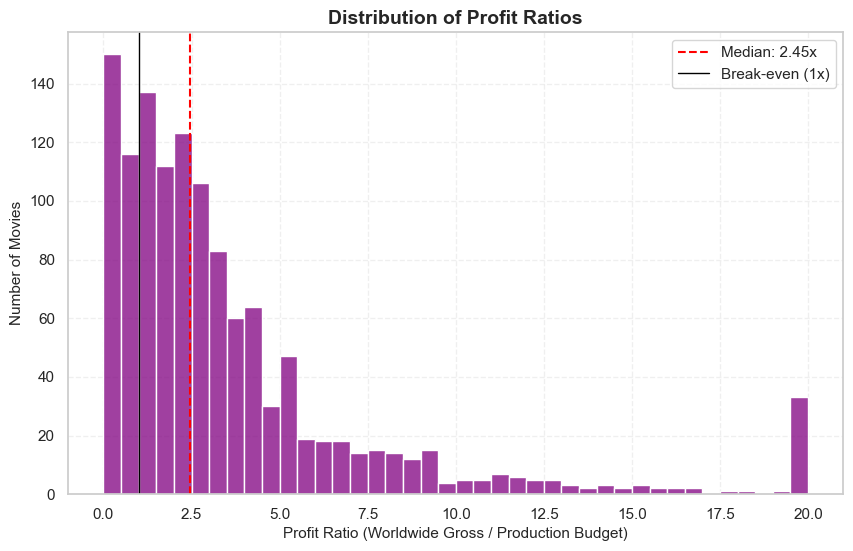

In [822]:
plt.figure(figsize=(10, 6))
sns.histplot(df_box['profit_ratio'], bins=40, color='purple')
plt.title('Distribution of Profit Ratios', fontsize=14, fontweight='bold')
plt.xlabel('Profit Ratio (Worldwide Gross / Production Budget)', fontsize=11)
plt.ylabel('Number of Movies', fontsize=11)
plt.axvline(df_box['profit_ratio'].median(), color='red', linestyle='--', 
            label=f'Median: {df_box["profit_ratio"].median():.2f}x')
plt.axvline(1, color='black', linestyle='-', linewidth=1, label='Break-even (1x)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


# Top 10 Studios by Average profit

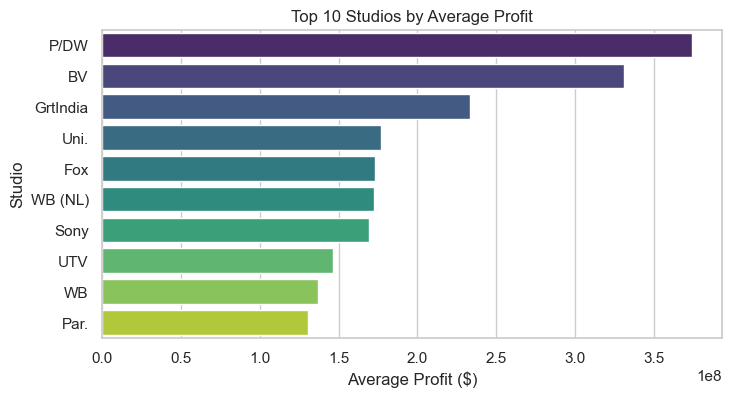

In [823]:
# compute total profit
df_box['profit'] = df_box['worldwide_gross'] - df_box['production_budget']

top_studios = df_box.groupby('studio')['profit'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_studios.values, y=top_studios.index, palette='viridis')

plt.title('Top 10 Studios by Average Profit')
plt.xlabel('Average Profit ($)')
plt.ylabel('Studio')
plt.show()


# Profit Distribution across top 5 studios

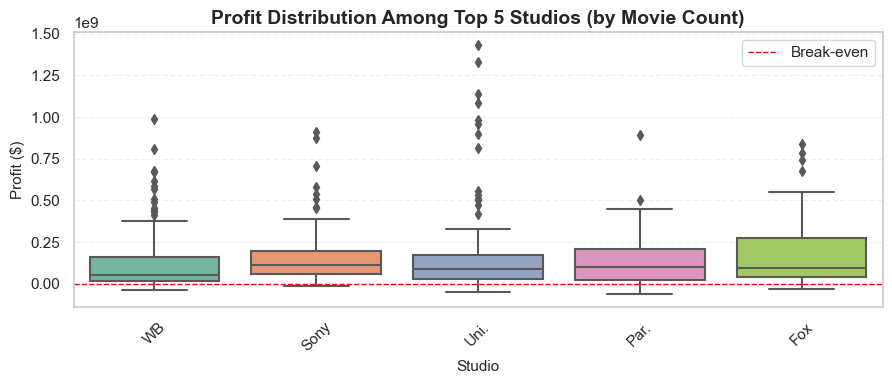

In [824]:
# Select top 5 studios by movie count
top5_studios = df_box['studio'].value_counts().head(5).index

plt.figure(figsize=(9, 4))
sns.boxplot(x='studio', y='profit', data=df_box[df_box['studio'].isin(top5_studios)], palette='Set2')
plt.title('Profit Distribution Among Top 5 Studios (by Movie Count)', fontsize=14, fontweight='bold')
plt.xlabel('Studio', fontsize=11)
plt.ylabel('Profit ($)', fontsize=11)
plt.xticks(rotation=45)
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Break-even')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Distribution of genres in our dataset

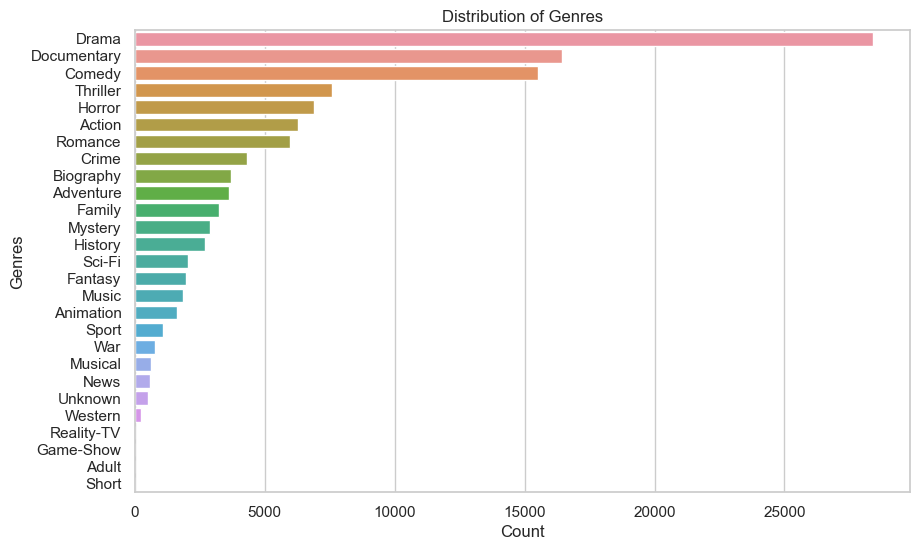

In [825]:
# Distribution of genres
plt.figure(figsize=(10, 6))
movie_basics_and_rating_exploded = movie_basics_ratings['genres'].str.split(',').explode()
sns.countplot(y=movie_basics_and_rating_exploded, order=movie_basics_and_rating_exploded.value_counts().index)
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.show()

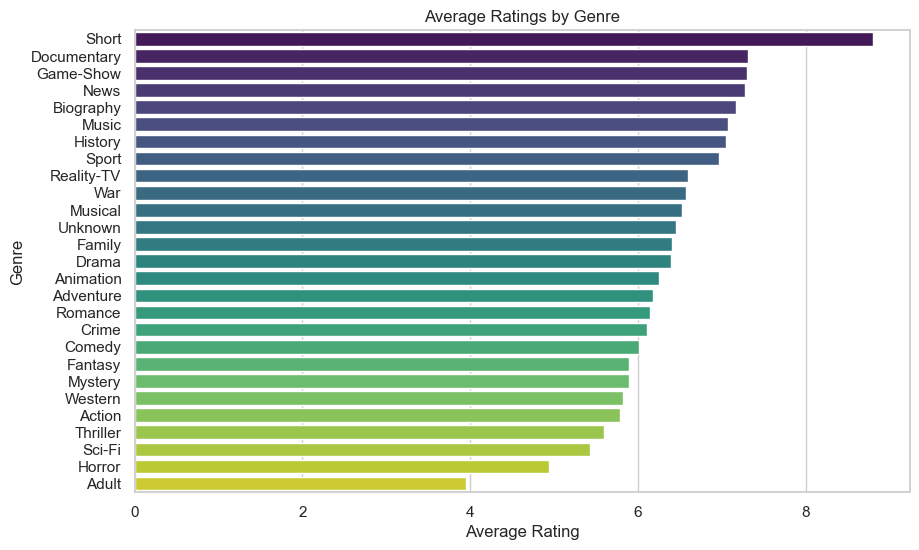

In [826]:
# Exploding genres to handle multiple genres per movie
movie_basics_ratings_exploded = movie_basics_ratings.assign(genres=movie_basics_ratings['genres'].str.split(',')).explode('genres')

# Calculating the average rating for each genre
genre_avg_rating = movie_basics_ratings_exploded.groupby('genres')['averagerating'].mean().reset_index().sort_values(by = 'averagerating', ascending=False)


# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='averagerating', y='genres', data=genre_avg_rating, palette='viridis')
plt.title('Average Ratings by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

# top genres by average rating

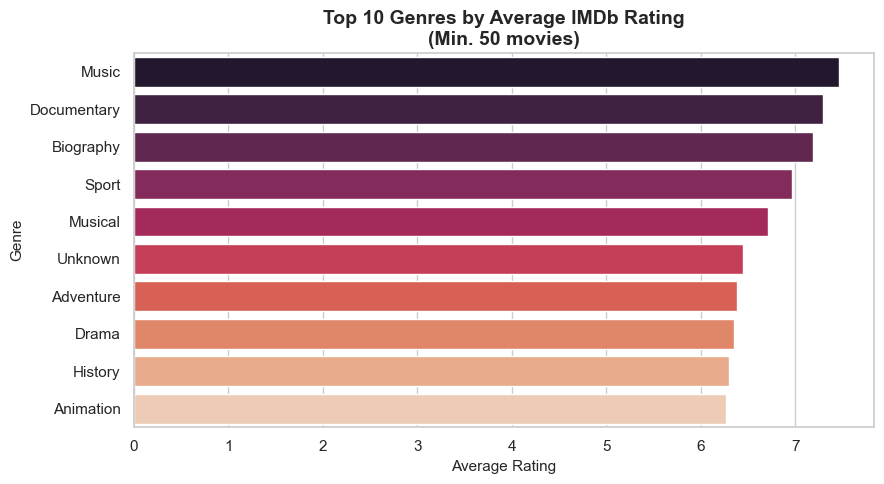

In [827]:
# Extract primary genre (first genre listed)
movie_basics_ratings['primary_genre'] = movie_basics_ratings['genres'].apply(lambda x: x.split(',')[0] if pd.notna(x) else 'Unknown')

# Filter genres with at least 50 movies
genre_counts = movie_basics_ratings['primary_genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 50].index

genre_ratings = movie_basics_ratings[movie_basics_ratings['primary_genre'].isin(valid_genres)].groupby('primary_genre')['averagerating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(9, 5))
sns.barplot(x=genre_ratings.values, y=genre_ratings.index, palette='rocket')
plt.title('Top 10 Genres by Average IMDb Rating\n(Min. 50 movies)', fontsize=14, fontweight='bold')
plt.xlabel('Average Rating', fontsize=11)
plt.ylabel('Genre', fontsize=11)
plt.tight_layout()
plt.show()

# What movies have been the most successful financially?
To answer this question, we look at the box office gross earnings and profits of various movies.

In [828]:
# check the top perfoming movies
top_20_movies_world=movie_budgets.nlargest (n=20, columns='worldwide_gross')
top_20_movies_domestic = movie_budgets.nlargest(n=20, columns ='domestic_gross')

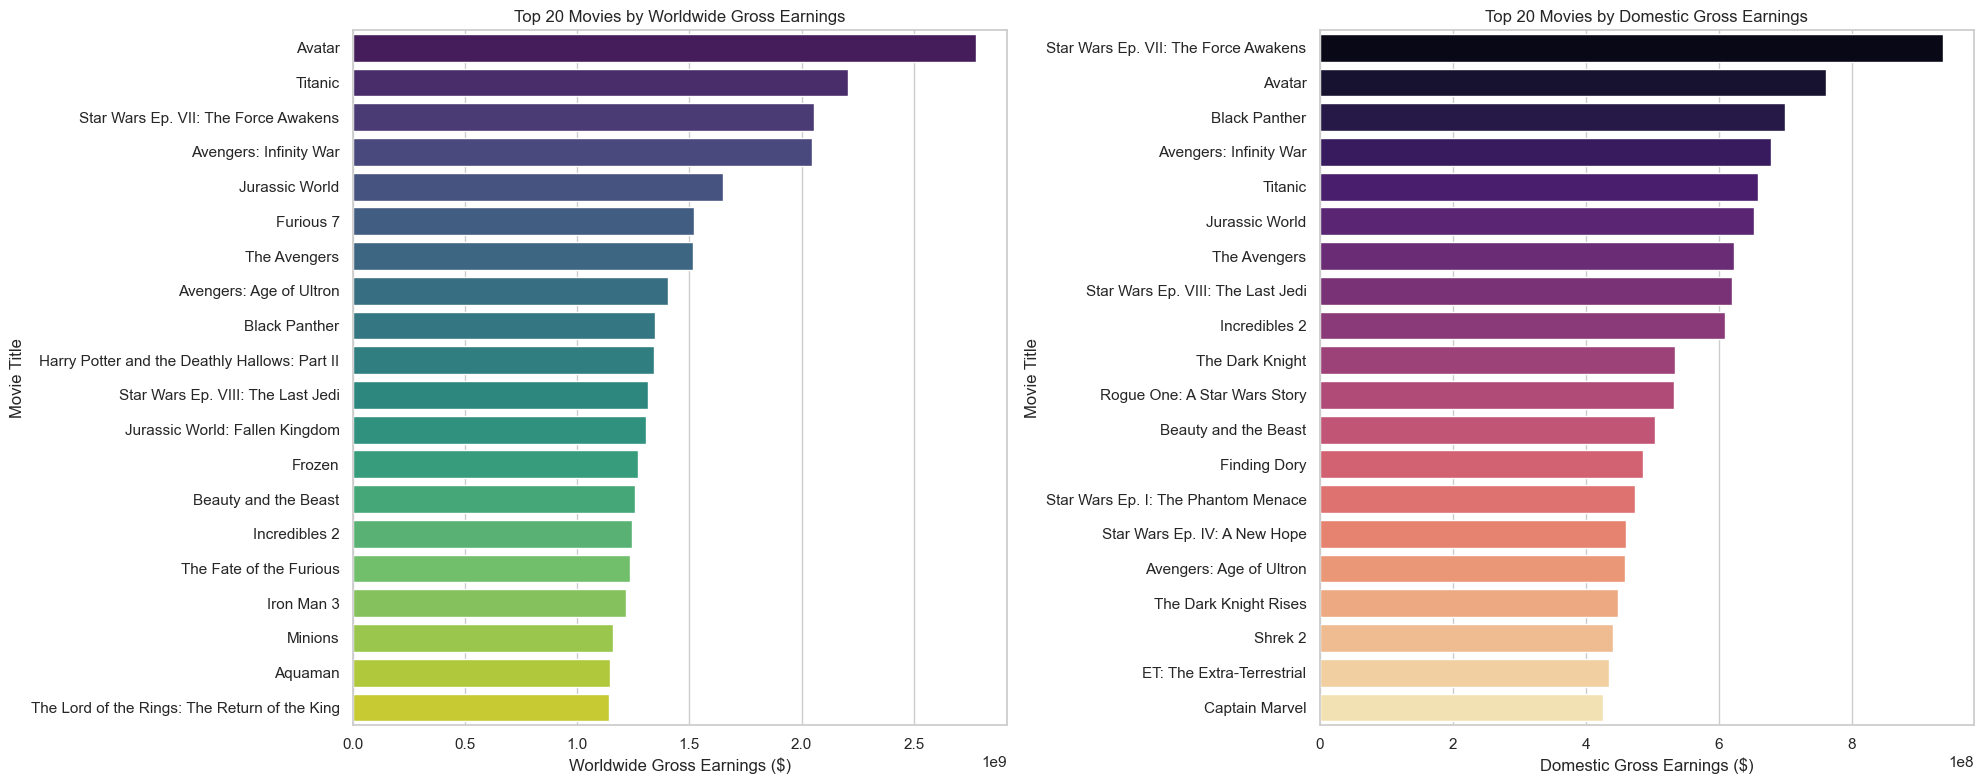

In [829]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot for worldwide gross earnings
sns.barplot(x='worldwide_gross', y='movie', data=top_20_movies_world, ax=axes[0], palette='viridis')
axes[0].set_xlabel('Worldwide Gross Earnings ($)')
axes[0].set_ylabel('Movie Title')
axes[0].set_title('Top 20 Movies by Worldwide Gross Earnings')

# Plot for domestic gross earnings
sns.barplot(x='domestic_gross', y='movie', data=top_20_movies_domestic, ax=axes[1], palette='magma')
axes[1].set_xlabel('Domestic Gross Earnings ($)')
axes[1].set_ylabel('Movie Title')
axes[1].set_title('Top 20 Movies by Domestic Gross Earnings')

# Adjust layout
plt.tight_layout()

# plt.savefig('top_20_movies_by_gross.png', dpi=300, bbox_inches='tight')

# Show the plots
plt.show()

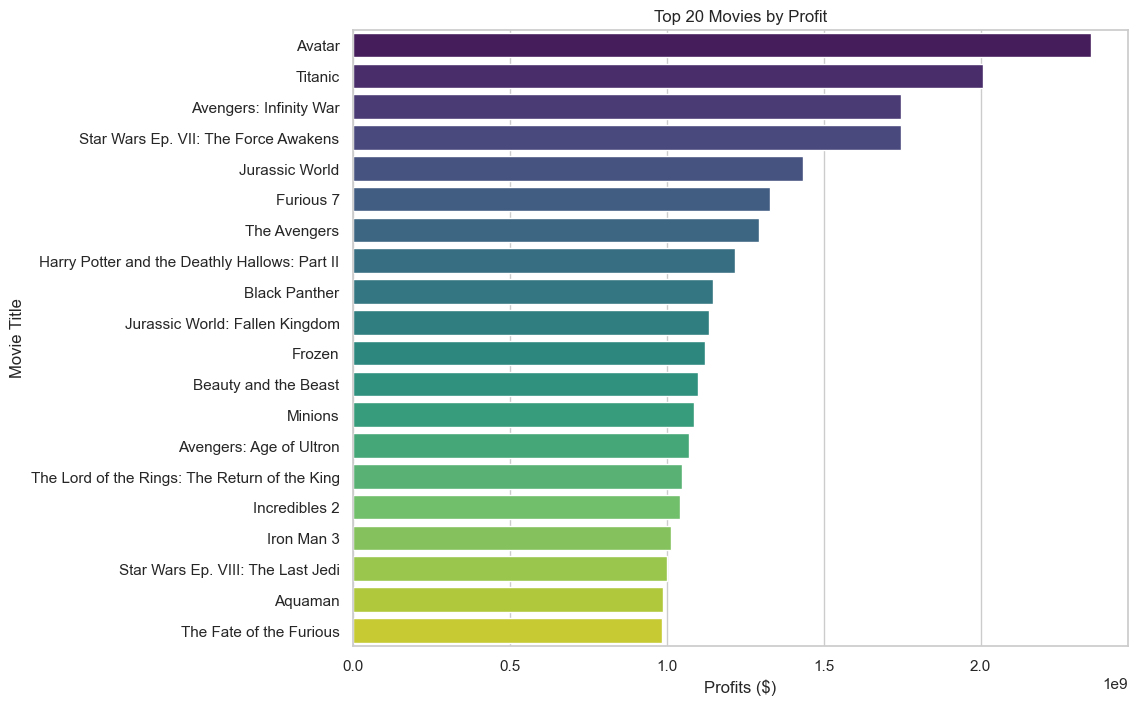

In [830]:
fig , ax = plt.subplots(figsize = (10,8))
# get the top 20 profitable movies
top_profitable = movie_budgets.nlargest(n = 20, columns= 'profit')

sns.barplot(x='profit', y='movie', data=top_profitable, ax=ax, palette='viridis')

# Set axis labels and title
ax.set_xlabel('Profits ($)')
ax.set_ylabel('Movie Title')
plt.title('Top 20 Movies by Profit')

# plt.savefig('top_20_movies_by_profit.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

### Analysing the relationship between `domestic_gross`, `worlwide_gross` and `profit`   

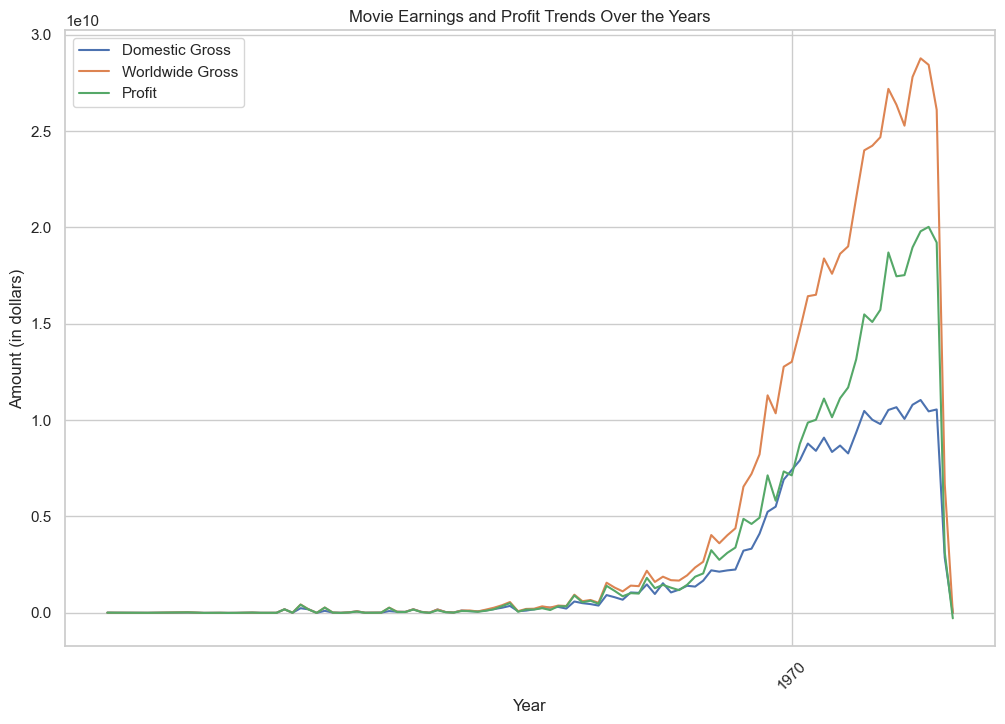

In [831]:
# plot movie earnings trends over the years and profits
# Aggregate data by year
yearly_data = movie_budgets.groupby('year').agg({
    'domestic_gross': 'sum',
    'worldwide_gross': 'sum',
    'profit': 'sum'
}).reset_index()

# Plot the trends
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data=yearly_data, x='year', y='domestic_gross', label='Domestic Gross', ax=ax)
sns.lineplot(data=yearly_data, x='year', y='worldwide_gross', label='Worldwide Gross', ax=ax)
sns.lineplot(data=yearly_data, x='year', y='profit', label='Profit', ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('Amount (in dollars)')
ax.set_title('Movie Earnings and Profit Trends Over the Years')
plt.xticks(rotation=45)
plt.legend()

plt.show()

Over time, we notice `domestic_gross`, `worldwide_gross` and `profit` have been generally increasing. 


To further understand `worldwide_gross`by month, we plot the average and total gross revenue by month. 

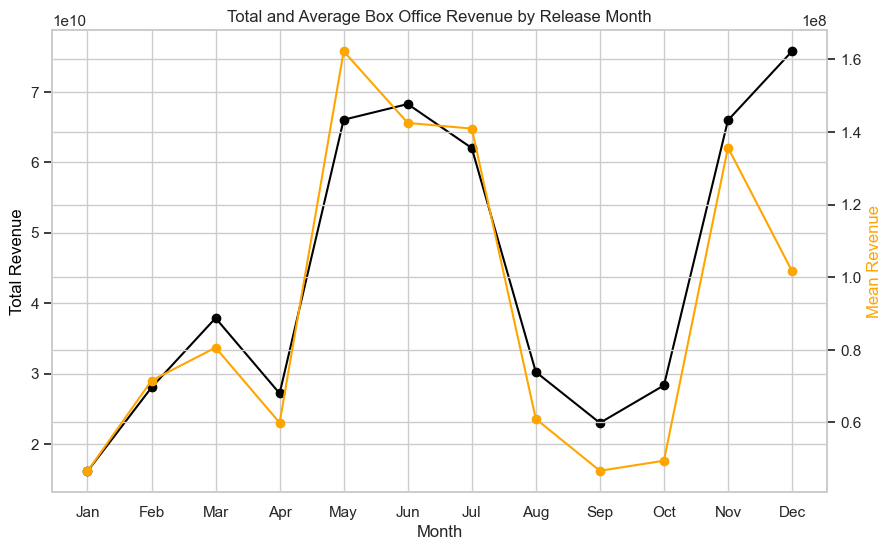

In [832]:
# Extract month number
movie_budgets['month'] = movie_budgets['release_date'].dt.month

# Now group by month and calculate total & average revenue
monthly_revenue = movie_budgets.groupby('month')['worldwide_gross'].agg(['sum', 'mean']).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel('Month')
ax1.set_ylabel('Total Revenue', color="black")
ax1.plot(monthly_revenue['month'].to_numpy(),
         monthly_revenue['sum'].to_numpy(),
         color="black", marker='o', label='Total Revenue')

ax2 = ax1.twinx()
ax2.set_ylabel('Mean Revenue', color="orange")
ax2.plot(monthly_revenue['month'].to_numpy(),
    monthly_revenue['mean'].to_numpy(),
    color="orange",
    marker='o',
    label='Mean Revenue')

plt.title('Total and Average Box Office Revenue by Release Month')
plt.xticks(monthly_revenue['month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


From the above graph, we notice that while May, November and December have the highest revenues, on average, May, June and July are the highest performing.

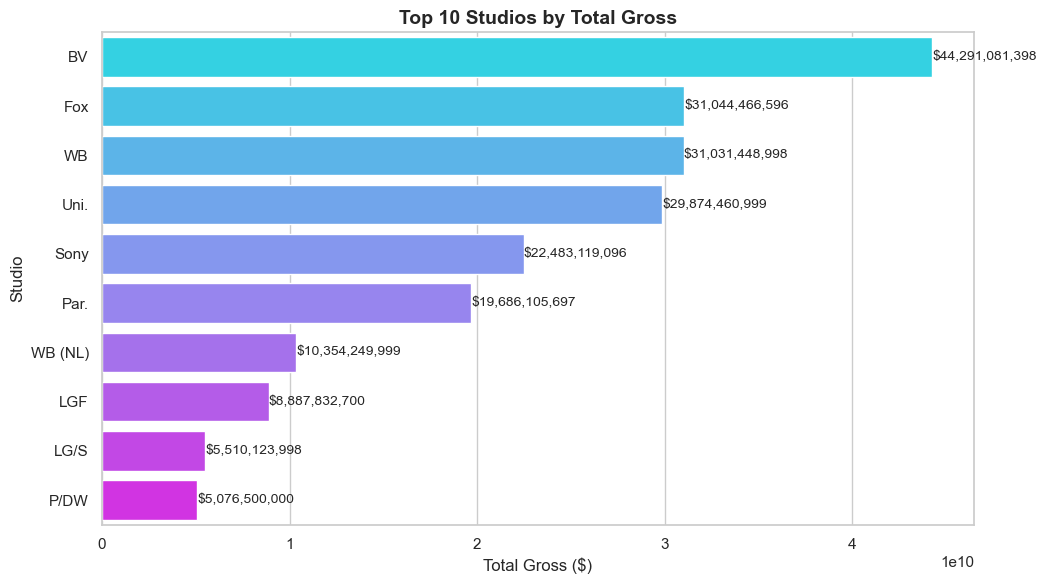

In [833]:
# total gross per studio
movie_gross['total_gross'] = movie_gross['domestic_gross'] + movie_gross['foreign_gross']

studio_gross = (
    movie_gross.groupby('studio')['total_gross']
       .sum()
       .sort_values(ascending=False)
       .head(10)
       .reset_index()
)

# Plot total gross for top 10 studios
plt.figure(figsize=(10,6))
sns.barplot(data=studio_gross, x='total_gross', y='studio', palette='cool')
plt.title('Top 10 Studios by Total Gross', fontsize=14, weight='bold')
plt.xlabel('Total Gross ($)')
plt.ylabel('Studio')
plt.tight_layout()

for i, v in enumerate(studio_gross['total_gross']):
    plt.text(v, i, f'${v:,.0f}', va='center', fontsize=10)

plt.show()


### try popularity against ratings over time

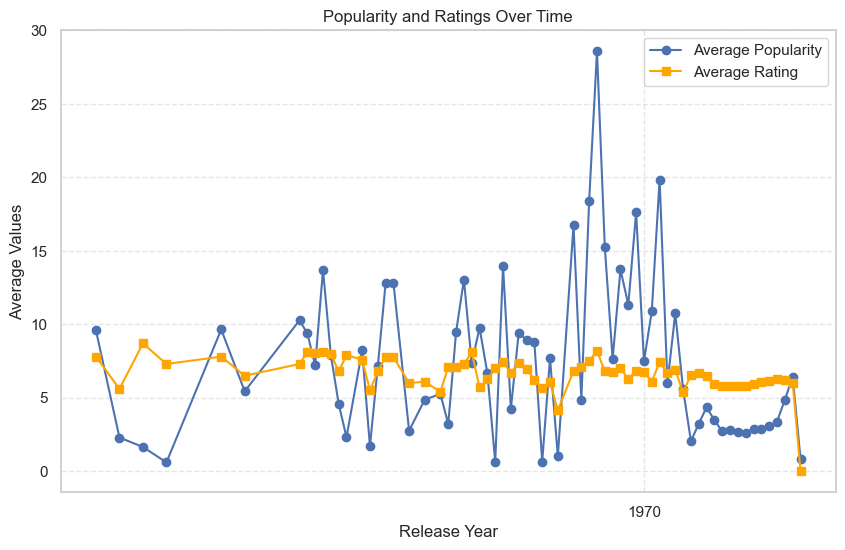

In [834]:
# Group by year and compute average popularity and rating
yearly_stats = tmdb_movies.groupby('year')[['popularity', 'vote_average']].mean()

plt.figure(figsize=(10, 6))
plt.plot(yearly_stats.index.to_numpy(), yearly_stats['popularity'].to_numpy(), marker='o', label='Average Popularity')
plt.plot(yearly_stats.index.to_numpy(), yearly_stats['vote_average'].to_numpy(), marker='s', label='Average Rating', color='orange')

plt.title('Popularity and Ratings Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Values')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [835]:
yearly_stats.head()
yearly_stats.columns
type(yearly_stats.index)


pandas.core.indexes.datetimes.DatetimeIndex

### How does the movie budget impact box office revenue, and can smaller budget films be profitable?

UFuncTypeError: Cannot cast ufunc 'svd_n_s' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

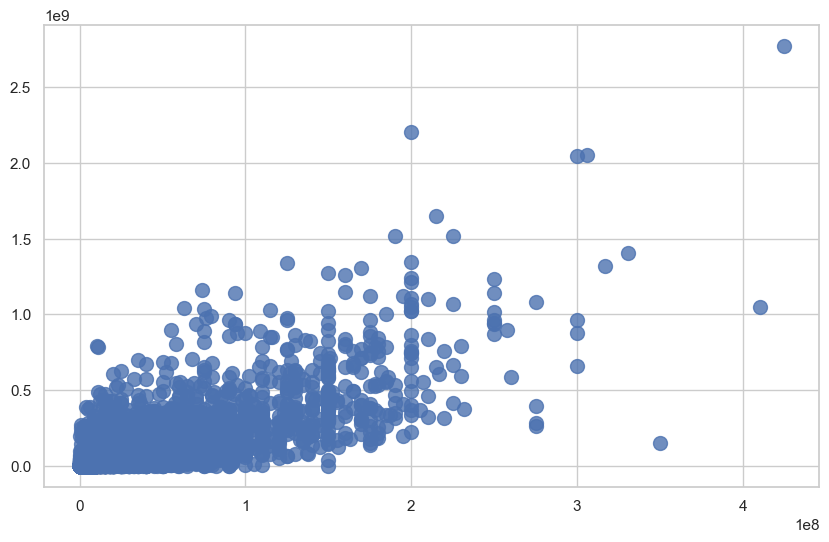

In [836]:
# How does the movie budget impact box office revenue, and can smaller budget films be profitable?
# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='production_budget', y='worldwide_gross', data=movie_budgets, scatter_kws={'s':100}, line_kws={'color':'red'})

# Customize the plot
plt.title('Effect of Production Budget on worldwide gross')
plt.xlabel('Production Budget')
plt.ylabel('worldwide gross')

# Show the plot
plt.show()

The plot above shows an that the gross revenue from movies has generally increased from 1920 to 2020. This suggests that movies release in later years tend to earn more revenue.

# Correlation between domestic and foreign earnings

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='domestic_gross_y', y='foreign_gross', data=df_box, alpha=0.6)
sns.regplot(x='domestic_gross_y', y='foreign_gross', data=df_box, scatter=False, color='red')
plt.title('Domestic vs Foreign Gross')
plt.xlabel('Domestic Gross ($)')
plt.ylabel('Foreign Gross ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Correlation heatmap
This shows how numeric features relate to each other

In [ ]:
plt.figure(figsize=(8,6))
numeric_cols = ['production_budget', 'domestic_gross_y', 'foreign_gross', 'worldwide_gross', 'profit', 'profit_ratio']
sns.heatmap(df_box[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Financial Metrics')
plt.show()


This visualization quantifies the linear relationships between key financial metrics.

**Key Correlations:**
- **Production Budget & Worldwide Gross (0.78):** Strong positive correlation. Higher budgets are associated with higher revenues.
- **Domestic Gross & Worldwide Gross (0.94):** Very strong correlation. Domestic performance is a very good indicator of total global performance.
- **Profit & Worldwide Gross (0.98):** Near-perfect correlation, which is logical as profit is derived directly from gross and budget.
- **Profit Ratio & Production Budget (-0.09):** A very weak, slightly negative correlation. This is a critical insight: **spending more does not guarantee a better return on investment (ROI)**. Higher budgets lead to higher absolute profits but can often lead to less efficient returns.


# **Statistical Hypothesis Testing**

We conduct rigorous statistical tests to validate our observations.

# Hypothesis Test 1: Domestic vs. Foreign Gross

To check whether domestic gross is significantly different from foreign gross for the same movie

In [ ]:
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(df_box['domestic_gross_y'], df_box['foreign_gross'])
print("t-statistic:", t_stat)
print("p-value:", p_val)

print("                     ")
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: Significant difference between domestic and foreign gross.")
else:
    print("Fail to reject the null hypothesis: No significant difference between domestic and foreign gross.")
    

- **Test:** Paired t-test (we have two measurements for the same movies).
- **Result:** p-value is extremely small (≈5e-28), far below 0.05.
- **Conclusion:** We reject the null hypothesis. There is a statistically significant difference between domestic and foreign gross. This confirms our EDA observation that the markets are distinct.

# Hypothesis Test 2: Studio Profitability


- **Null Hypothesis (H0):** The average profit is the same across the top 5 studios.
- **Alternative Hypothesis (H1):** At least one studio's average profit is different.

In [ ]:
from scipy.stats import f_oneway

# Select top 5 studios by number of movies
top_studios = df_box['studio'].value_counts().head(5).index
profits_by_studio = [df_box[df_box['studio']==studio]['profit'] for studio in top_studios]

f_stat, p_val = f_oneway(*profits_by_studio)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")

print("             ")
alpha = 0.05
if p_val < alpha:
    print("Reject Null Hypothesis (H₀): There is a significant difference in average profits among the studio")
else:
    print("Fail to Reject Null Hypothesis (H₀): There is no significant difference in average profits among the studios.")


- **Result:** p-value = 0.4136, which is greater than 0.05.
- **Conclusion:** We fail to reject the null hypothesis. There is no statistically significant evidence that the average profits of the top studios differ. This supports the box plot insight that studio brand alone isn't a major differentiator in average profitability.

## Hypothesis 3: High vs Low Budget Movie Profitability

**Null Hypothesis (H₀)**: High-budget and low-budget movies have the same average profit ratio.

**Alternative Hypothesis (H₁)**: High-budget and low-budget movies have different average profit ratios.

**Test**: Independent two-sample t-test

In [ ]:
from scipy.stats import ttest_ind

# Define high and low budget categories (median split)
median_budget = df_box['production_budget'].median()
df_box['budget_category'] = df_box['production_budget'].apply(
    lambda x: 'High' if x >= median_budget else 'Low'
)

high_budget_ratio = df_box[df_box['budget_category'] == 'High']['profit_ratio']
low_budget_ratio = df_box[df_box['budget_category'] == 'Low']['profit_ratio']

# Conduct independent t-test
t_stat, p_val = ttest_ind(high_budget_ratio, low_budget_ratio)


print("HYPOTHESIS TEST 4: High vs Low Budget Movie Profitability")
print(" ")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.4f}")
print("\nNull Hypothesis (H₀): There is no difference in profit ratios between high- and low-budget movies.")
print("Alternative Hypothesis (H₁): There is a significant difference in profit ratios between high- and low-budget movies.")


 We reject the null hypothesis. There is a significant difference. The negative t-statistic indicates that the high-budget group has a lower average profit ratio than the low-budget group. This is a crucial finding: while big budgets make more money in absolute terms, they are less efficient in terms of ROI.

## Hypothesis 4: Genre and Rating Relationship

**Null Hypothesis (H₀)**: All genres have the same average IMDb rating.

**Alternative Hypothesis (H₁)**: At least one genre has a different average rating.

**Test**: One-way ANOVA

In [ ]:
# Select top 5 genres by frequency
top5_genres = df_imdb['primary_genre'].value_counts().head(5).index
ratings_by_genre = [df_imdb[df_imdb['primary_genre'] == genre]['averagerating'] for genre in top5_genres]

# Conduct ANOVA
f_stat, p_val = f_oneway(*ratings_by_genre)

print("HYPOTHESIS TEST 5: Genre and Rating Relationship")
print("   ")
print(f"Test: One-way ANOVA")
print(f"Genres tested: {', '.join(top5_genres)}")
print(f"\nF-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4e}")
print(f"\nSignificance level: α = 0.05")

if p_val < 0.05:
    print(f"\n REJECT the null hypothesis: There IS a significant difference in ratings across genres.")
    
    print(f"\nAverage Ratings by Genre:")
    for genre in top5_genres:
        avg_rating = df_imdb[df_imdb['primary_genre'] == genre]['averagerating'].mean()
        print(f"  {genre}: {avg_rating:.2f}")
else:
    print(f"\n FAIL TO REJECT the null hypothesis: No significant difference in ratings across these genres.")

We reject the null hypothesis. There is a significant difference in ratings across genres. The follow-up analysis of means shows a clear hierarchy: Documentaries and Dramas are rated highly, while Horror and Action films receive lower average ratings from audiences.



# Predictive Modeling

A simple linear regression model to predict worldwide gross.


In [ ]:
# Prepare features for modeling

df_model = df_box[['production_budget', 'domestic_gross_y', 'foreign_gross', 'worldwide_gross']].dropna()
# This line selects only the 4 columns needed for modeling.
# .dropna() removes any rows that contain missing (NaN) values in any of these columns.

# Features and target
X = df_model[['production_budget']]
y = df_model['worldwide_gross']

# X (features) = the independent variable - production budget.
# y (target) = the dependent variable - worldwide gross revenue.

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 80% of data is used to train the model, 20% to test it.
# random_state=42 ensures reproducibility (same random split every time).

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("PREDICTIVE MODEL: Production Budget → Worldwide Gross")
print(" ")
print(f"Model: Linear Regression")
print(f"Features: Production Budget")
print(f"Target: Worldwide Gross")
print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"\nModel Performance:")
print(f"  R² Score: {r2:.4f}")
print(f"  RMSE: ${rmse/1e6:.2f}M")
print(f"\nRegression Equation:")
print(f"  Worldwide Gross = ${model.intercept_/1e6:.2f}M + {model.coef_[0]:.4f} × Budget")
print(f"\nInterpretation:")
print(f"  For every $1M increase in budget, worldwide gross increases by ${model.coef_[0]*1e6/1e6:.4f}M")


## Predictive Modeling: Budget to Gross Prediction
We build a simple linear regression model to predict a movie's worldwide gross based solely on its production budget.

**Model Performance:**
- **R² Score:** 0.58 - This means that 58% of the variance in worldwide gross can be explained by the production budget. It's a moderate fit, indicating that budget is a important, but not the only, factor in a movie's success.

- **RMSE:** $131.05 Million - On average, our model's predictions are off by about $131 million. This large error underscores the high uncertainty in the movie business.
- **Regression Equation:** `Worldwide Gross = -4.23M + 3.32 * Budget`
- **Interpretation:** For every additional $1 million spent on production, the model predicts an average increase of $3.32 million in worldwide gross. The negative intercept is a mathematical artifact of the model and not practically meaningful in this context.

**Conclusion:** Budget is a powerful predictor, but other factors (genre, star power, marketing, competition, release date) play a massive role in determining final box office performance.

In [ ]:
# Visualization
plt.figure(figsize=(9, 5))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
        'r--', linewidth=2, label='Perfect Prediction')
plt.title(f'Predicted vs Actual Worldwide Gross\nR² = {r2:.3f}', 
         fontsize=14, fontweight='bold')
plt.xlabel('Actual Worldwide Gross ($)', fontsize=11)
plt.ylabel('Predicted Worldwide Gross ($)', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Key Insights & Business Recommendations

### Summary of Validated Findings:
1.  **International is Key:** Foreign gross is significantly different and often larger than domestic gross.
2.  **The Budget Paradox:** Higher budgets lead to higher absolute profits but lower Return on Investment (ROI). Mid-budget films often offer the best risk-reward balance.
3.  **Studio is Not a Destiny:** No significant difference in average profit among top studios. Focus on the project, not just the studio logo.
4.  **Genre Matters for Ratings:** Genres have significantly different audience ratings, which can inform marketing and critical expectations.

### Actionable Recommendations:
- **For Producers:** Target mid-range budgets for optimal ROI and prioritize international appeal in story and marketing.
- **For Investors:** Diversify across genres and budgets; evaluate projects based on profit ratio, not just potential total gross.
- **For Marketers:** Tailor campaigns for domestic and international audiences separately and leverage high ratings when available for genres like Documentary or Drama.